In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors
from Analysis.helpers import load_from_path, save_image

In [2]:
# from mobo.surrogate_model import BoTorchSurrogateModelReapeat, BoTorchSurrogateModel
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import yaml

In [3]:
algos = ["qnehvi", "raqnehvi", "raqneirs"]
subfolder = "R3"
frmt = "pdf"
problem ="bstvert"
seed = 0

In [4]:
# Parameters
algos = ["qnehvi", "raqnehvi", "raqneirs"]
subfolder = "R10"
problem = "bstdiag"
seed = 0
frmt = "pdf"


In [5]:
from mobo.utils import calculate_var
path = Path(f"../result/{problem}/{subfolder}/{algos[0]}/{seed}")


import sys
sys.path.append(r'..\problems')
sys.path.append('.')

from problems.common import get_problem_options
prob_class = get_problem_options()[path.parts[2]]
prob = prob_class(sigma=0.5, repeat_eval=100000, alpha=0.9)

n_obj = prob.n_obj
bounds = prob.bounds
n = 30

x1 = np.linspace(bounds[0, 0], bounds[1, 0], n)
x2 = np.linspace(bounds[0, 1], bounds[1, 1], n)
x1, x2 = np.meshgrid(x1, x2)
X = np.stack([x1.flatten(), x2.flatten()]).T
Y = prob.f(X).reshape(n, n, 2)
rho_measured = prob._evaluate_rho(X).reshape(n, n, 2)
rho_real = prob.get_noise_var(X).reshape(n, n, 2)
Y_noise = prob._evaluate_F(X).reshape(n, n, 2)

VaR = calculate_var(Y.flatten(), variance=rho_real.flatten())
VaR = VaR.reshape(n, n, 2)

In [6]:
alphas = [0.9]
# alphas = list(reversed([0.5, 0.52, 0.6, 0.9, 0.99]))
Ys, Xs = prob.pareto_front(n_pareto_points=200, alphas=alphas, return_x=True)

SMOKE_TEST None


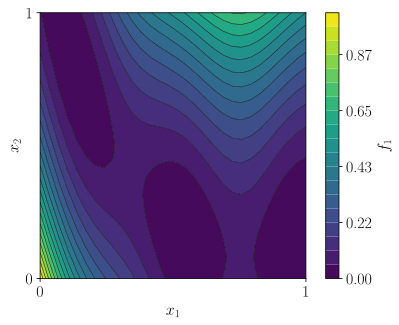

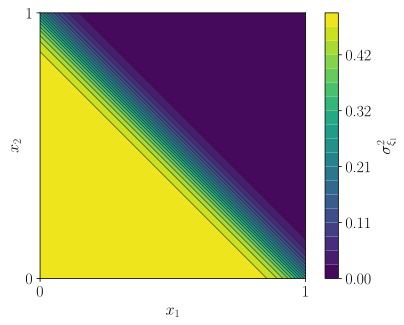

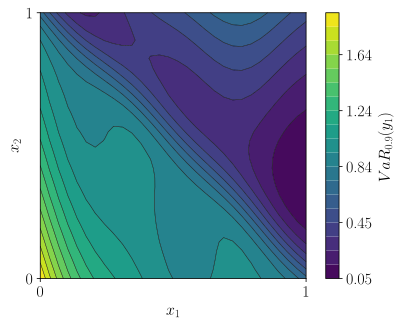

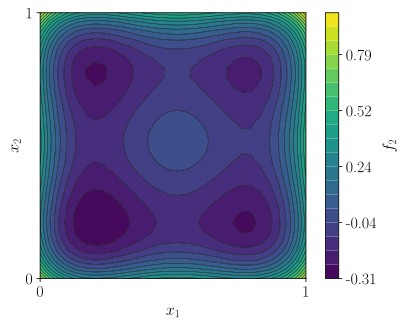

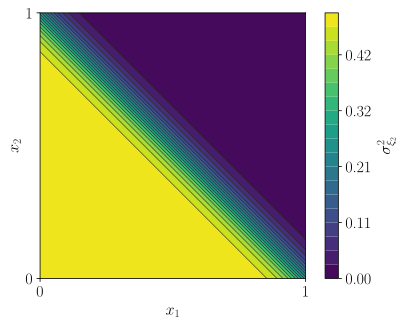

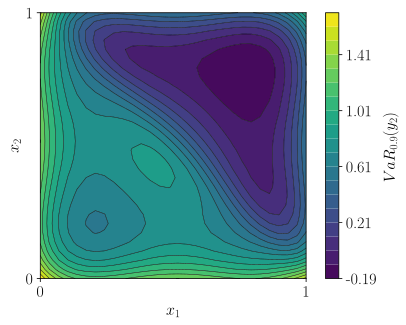

In [7]:
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}",
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    # font size
    "font.size": 16,
})

colors = defaultColors

objective_list = list(range(1,n_obj+1))
data_keys = ["F_", "rho_F_", "mvar_F_"]

# Y_list = [
#     Y[:, :, 0],
#     Y[:, :, 1],
#     rho_real[:, :, 0],
#     rho_real[:, :, 1],
#     VaR[:, :, 0],
#     VaR[:, :, 1],
# ]

Y_list_dict = {
    "F_1": Y[:, :, 0],
    "F_2": Y[:, :, 1],
    "rho_F_1": rho_real[:, :, 0],
    "rho_F_2": rho_real[:, :, 1],
    "mvar_F_1": VaR[:, :, 0],
    "mvar_F_2": VaR[:, :, 1],
}

x,y = x1, x2

approx_all_i = Y_list_dict



for i, obj_idx in enumerate(objective_list):
    for j, key in enumerate(data_keys):
        fig, ax = plt.subplots()
        # Construct the key for the current iteration
        current_key = f"{key}{obj_idx}"
        # Reshape the data for the current plot
        z = approx_all_i[current_key].reshape((n, n))
        levels = np.linspace(z.min(), z.max(), 20)
        # Create contour plot
        img = ax.contourf(x[0], y[:, 0], z, levels=levels, cmap="viridis")
        c = ax.contour(x[0], y[:, 0], z, levels=levels, colors='black', linestyles='solid', linewidths=0.5)
        # axs[i, j].clabel(c, c.levels[::2], inline=True, fontsize=10, colors='white', zorder=100)
        
            

        cb = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.1, pad=0.05, format="%.2f",
                     ticks=levels[::4])
        
        
        # Latex formatting
        if key == "F_":
            cb.set_label(f"$f_{obj_idx}$")
        if key == "rho_F_":
            cb.set_label(f"$\\sigma^2_{{\\xi_{obj_idx}}}$")
        if key == "mvar_F_":
            cb.set_label(f"$VaR_{{0.9}}({{y_{obj_idx}}})$")
            
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")

        ax.set(xticks=[x.min(), x.max()], yticks=[y.min(), y.max()])
        
        ax.set(xticks=[x.min(), x.max()], yticks=[y.min(), y.max()])
        

        ax.label_outer()
        
        # perfect square
        ax.set_aspect('equal', 'box')

        fig.tight_layout()

        save_image(fig, path, f"Benchmark_{problem}_{current_key}", format=frmt, bbox_inches='tight')
